# 0.0 Imports

In [1]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
    
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r,k = cm.shape
    chi2corr = max(0,chi2 - (((k-1)*(r-1))/(n-1)))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    v = np.sqrt( (chi2corr/n) / (min (kcorr-1,rcorr-1) ) )
    return v


    
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')    
            end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) 
                                             / start_mem))
    
    return df    

## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv',low_memory=False)
df_store_raw = pd.read_csv('data/store.csv',low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw,df_store_raw, how='left', on='Store')

# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:


cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase,cols_old))

df1.columns = cols_new

## 1.2 Data Dimensions

In [6]:
print(f'Number of rows {df1.shape[0]}')
print(f'Number of columns {df1.shape[1]}')

Number of rows 1017209
Number of columns 18


## 1.3 Data Type

In [7]:

df1['date'] = pd.to_datetime(df1['date'])

In [8]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
#competition_distance    
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month  
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)

#promo2_since_week   
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)


#promo2_since_year   

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)




In [11]:
#promo_interval  

month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis=1)

In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Data Types

In [13]:
# competiton 
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

#promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistics 

In [14]:


num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])



## 1.7.1 Numerical Attributes

In [15]:
#Central tendency -mean, median 

ct1= pd.DataFrame(num_attributes.apply(np.mean)).T
ct2= pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
metrics = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
metrics.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [16]:
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical attributes

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [18]:
jupyter_settings()


Populating the interactive namespace from numpy and matplotlib


/home/leonardo/rossman/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


<AxesSubplot:xlabel='assortment', ylabel='sales'>

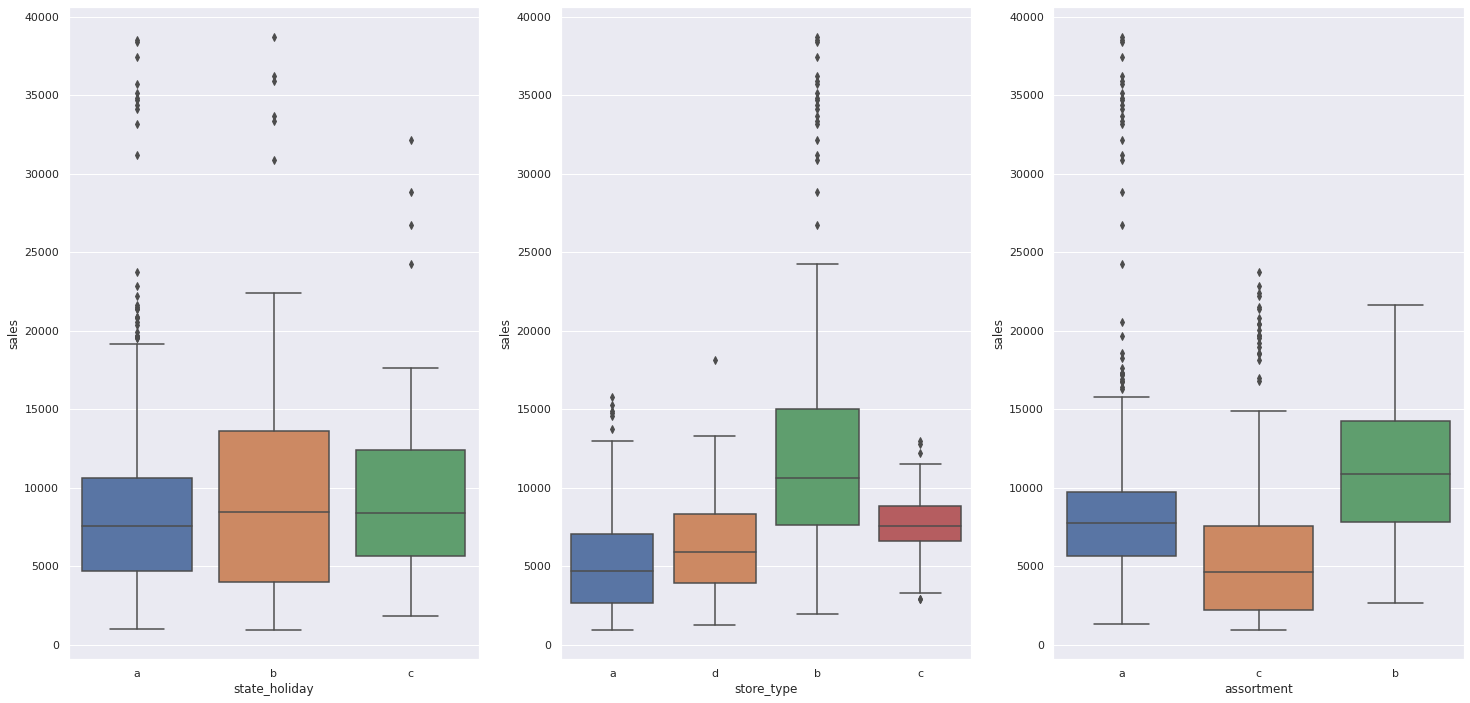

In [19]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

## 2.0 FEATURE ENGINEERING

In [20]:
df2= df1.copy()

## 2.1 Mind map hypotheses

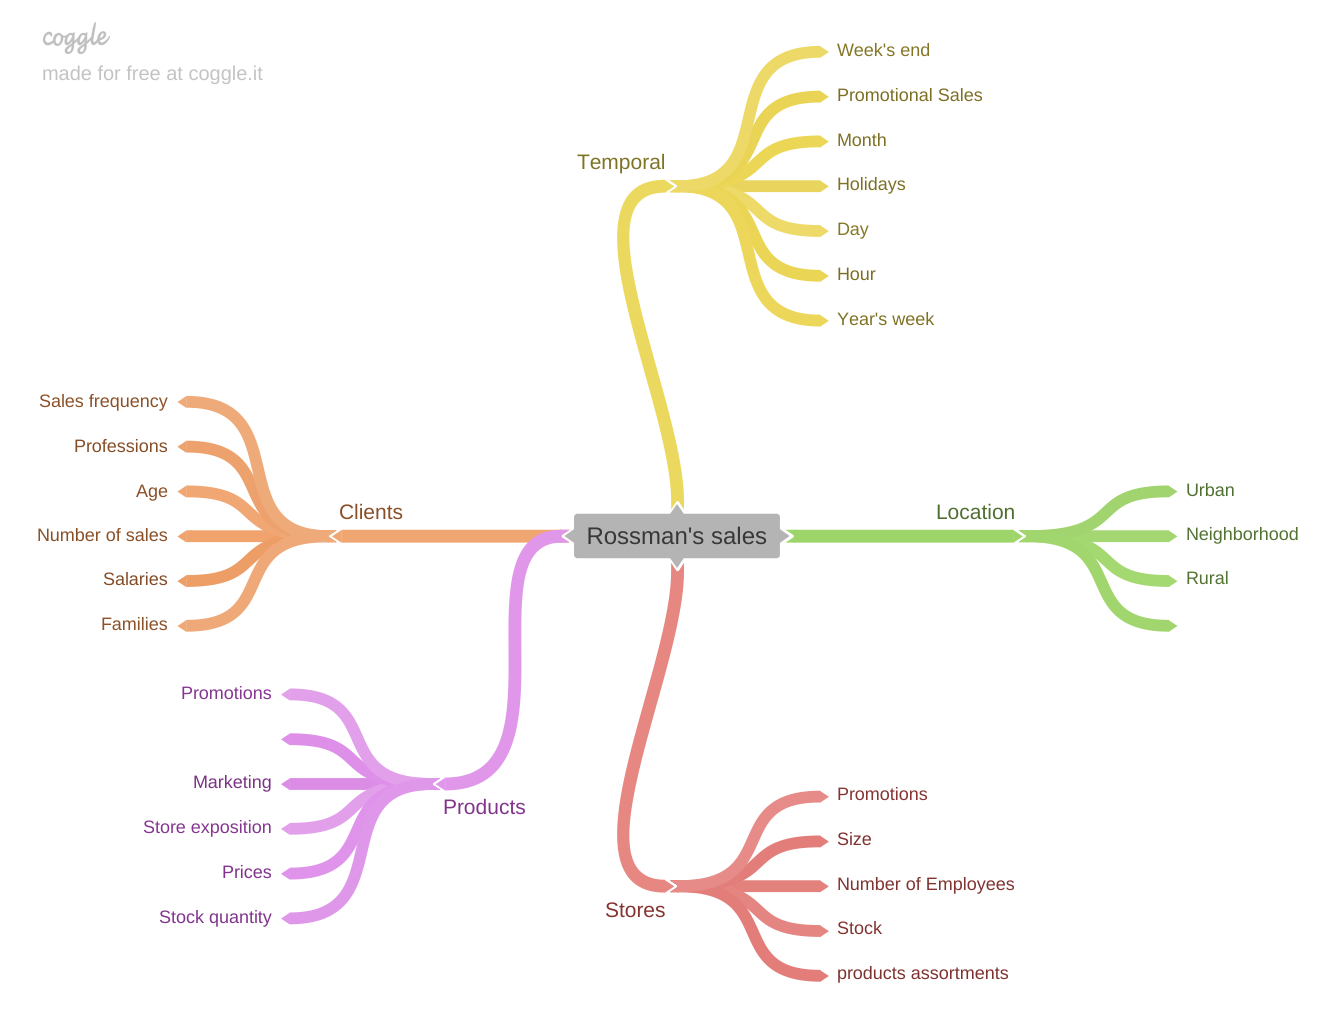

In [21]:
Image('img/mind_map.png')

### 2.1.1 Store hypotheses

**1-** Stores with a higher number of employees probably sell more

**2-** Stores with a higher number of stock probably sell more

**3-** Bigger stores probably sell more

**4-** Smaller stores probably sell less

**5-** Stores with a bigger products assortments probably sell more

**6-** Stores with a big amount of competitors probably sell less

**7-** Stores with competitors for a longer period of time probably sell more



### 2.1.2 Product hypotheses

**1-** Stores that invests more in marketing probably sell more

**2-** Stores with a bigger amount of products windows probably sell more

**3-** Stores with cheaper prices probably sell more

**4-** Stores with bigger time promotions probably sell more

**5-** Stores with active promotions for longer period of time probably sell more

**6-** Stores with a bigger amount of promotional days probably sell more

**7-** Stores with active promotions for longer period of time probably sell more

**8-** Stores with new consecutive promotions probably sell more


### 2.1.3 Temporal hypotheses

**1-** Stores where there's a bigger amount of holidays probably sell less

**2-** Stores open in the second semester of the year probably sell more

**3-** Stores that are open in week ends probably sell more

**4-** Stores probably sell more after each 10th day of month

**5-** Stores probably sell less in week ends

**6-** Stores probably sell less in scholar holidays

**7-** Stores open in Christmas holiday probably sell more

**8-** Stores that were open early probably sell more


## 2.2 Final list of hypotheses

**1-** Stores with a bigger products assortments probably sell more

**2-** Stores with a big amount of competitors probably sell less

**3-** Stores with competitors for a longer period of time probably sell more

**4-** Stores with active promotions for longer period of time probably sell more

**5-** Stores with a bigger amount of promotional days probably sell more

**6-** Stores with active promotions for longer period of time probably sell more

**7-** Stores with new consecutive promotions probably sell more

**8-** Stores open in Christmas holiday probably sell more

**9-** Stores that were open early probably sell more

**10-** Stores open in the second semester of the year probably sell more

**11-** Stores probably sell more after each 10th day of month

**12-** Stores probably sell less in week ends

**13-** Stores probably sell less in scholar holidays




## 2.3 Feature Engineering

In [22]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')




<ipython-input-22-6034d6dc66f8>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [23]:
#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month= x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)






In [24]:
#promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )
datetime.datetime.strptime

<function datetime.strptime>

In [25]:
#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == "a" else 'extra' if x == 'b' else 'extended') 


#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


# 3.0 Variable Filter

In [26]:
df3=df2.copy()

In [27]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Rows filter

In [28]:
df3 = df3[(df3['open'] !=0 ) & (df3['sales']) >0]


## 3.2 Columns selection

In [29]:
cols_drop = ['customers','open','promo_interval','month_map']

df3 = df3.drop(cols_drop,axis= 1)

# 4.0 EXPLORATORY DATA ANALYSIS

In [30]:
df4 = df3.copy()

## 4.1 Univariate analysis

### 4.1.1 Response Variable

/home/leonardo/rossman/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

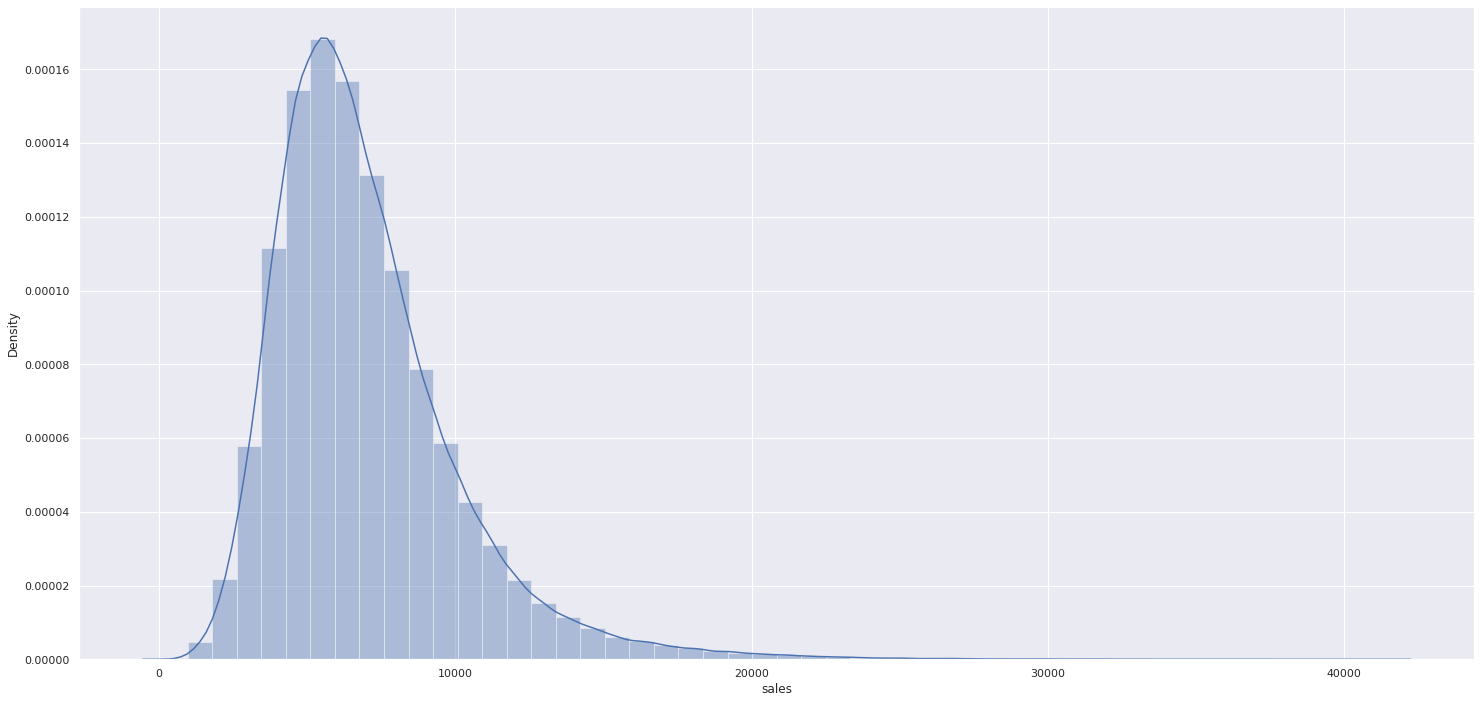

In [31]:
sns.distplot(df4['sales'])

### 4.1.2 Numerical Variable

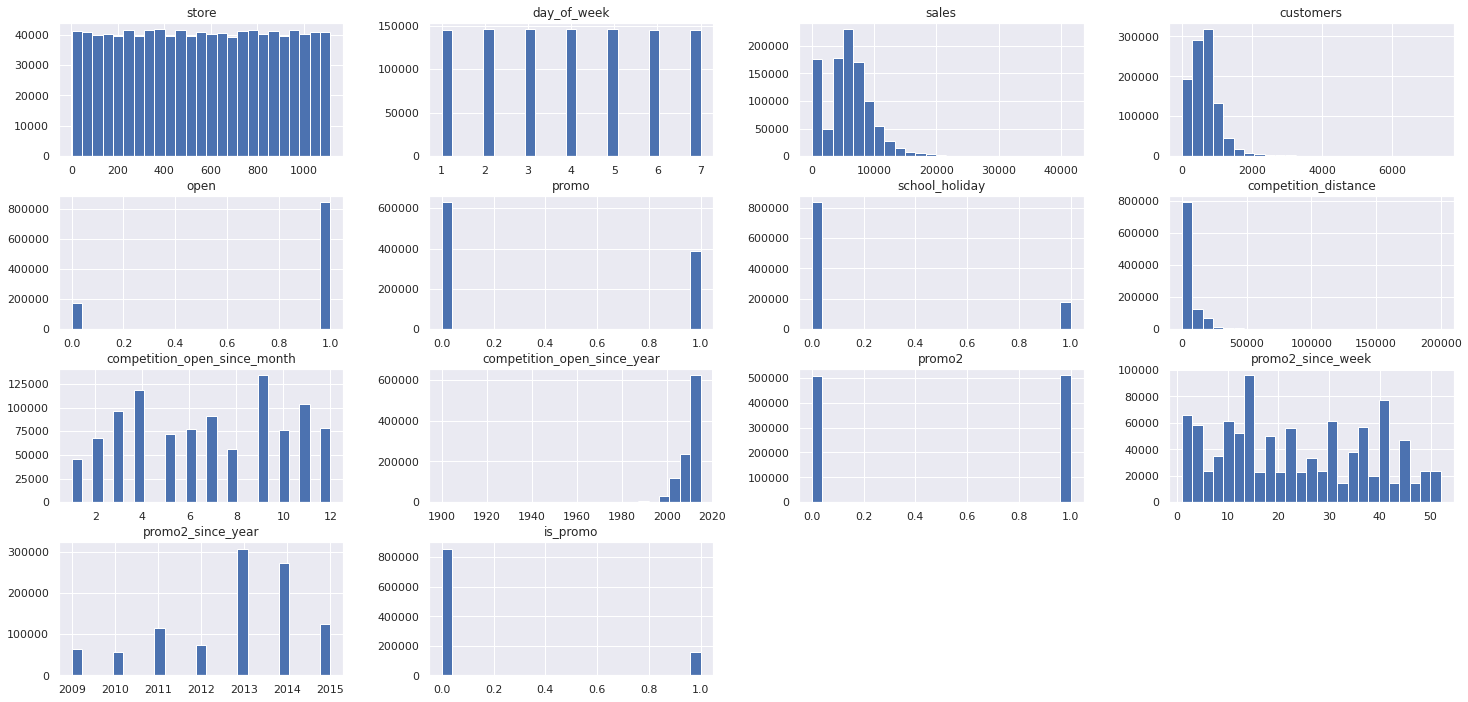

In [32]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variable

In [33]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
273       extra
Name: assortment, dtype: object

/home/leonardo/rossman/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/leonardo/rossman/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/leonardo/rossman/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

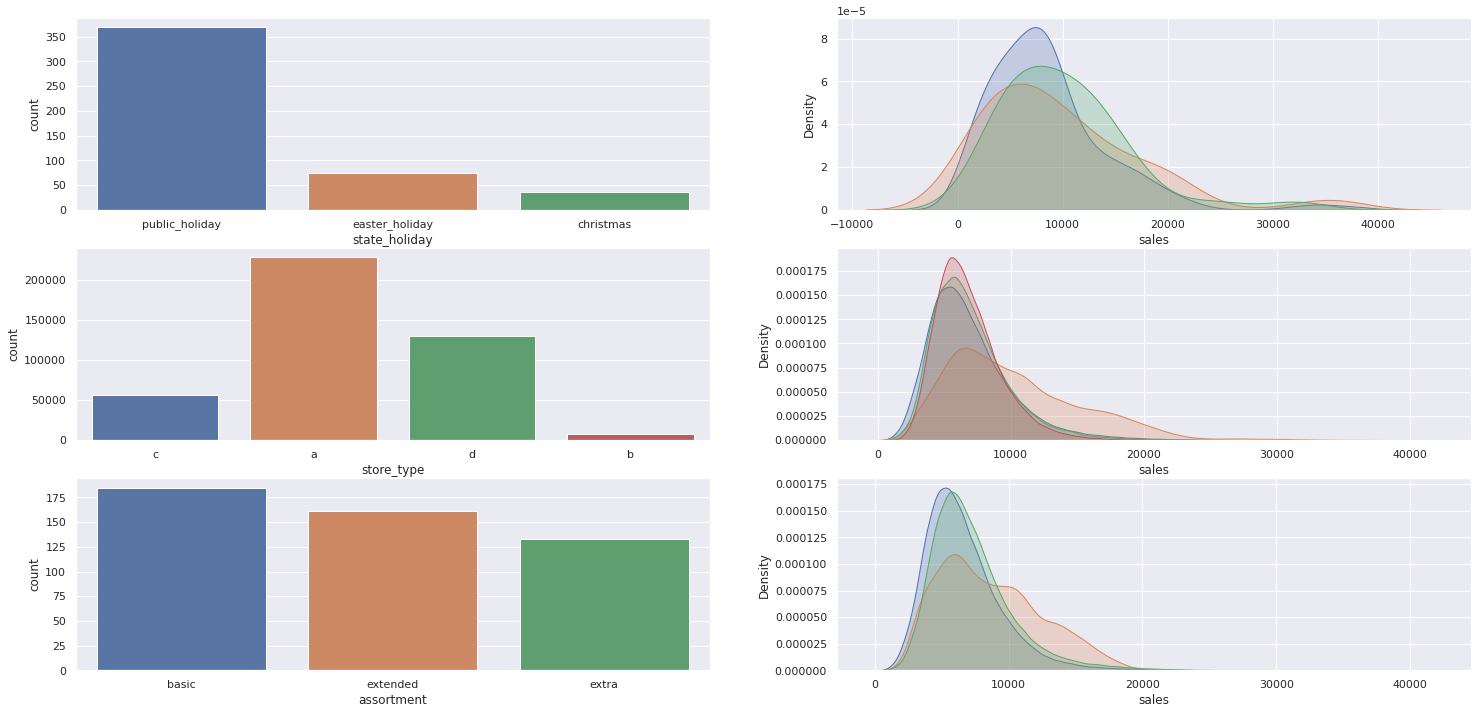

In [34]:
#state holiday 
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] =='public_holiday']['sales'],label='public_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] =='easter_holiday']['sales'],label='easter_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] =='christmas']['sales'],label='christmas',shade=True)

#store_type

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],label='a',shade=True)
sns.kdeplot(df4[df4['store_type']== 'b' ]['sales'],label='b',shade=True)
sns.kdeplot(df4[df4['store_type']== 'c' ]['sales'],label='c',shade=True)
sns.kdeplot(df4[df4['store_type']== 'd' ]['sales'],label='d',shade=True)

#assortment
plt.subplot(3,2,5)
sns.countplot(a['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] =='basic']['sales'],label='basic',shade=True)
sns.kdeplot(df4[df4['assortment'] =='extra']['sales'],label='extra',shade=True)
sns.kdeplot(df4[df4['assortment'] =='extended']['sales'],label='extended',shade=True)


## 4.2 Bivariate analysis

### 1- Stores with a bigger products assortments probably sell more



**FALSE** Actually stores with a bigger products assortments tends to sell less

<AxesSubplot:xlabel='year_week'>

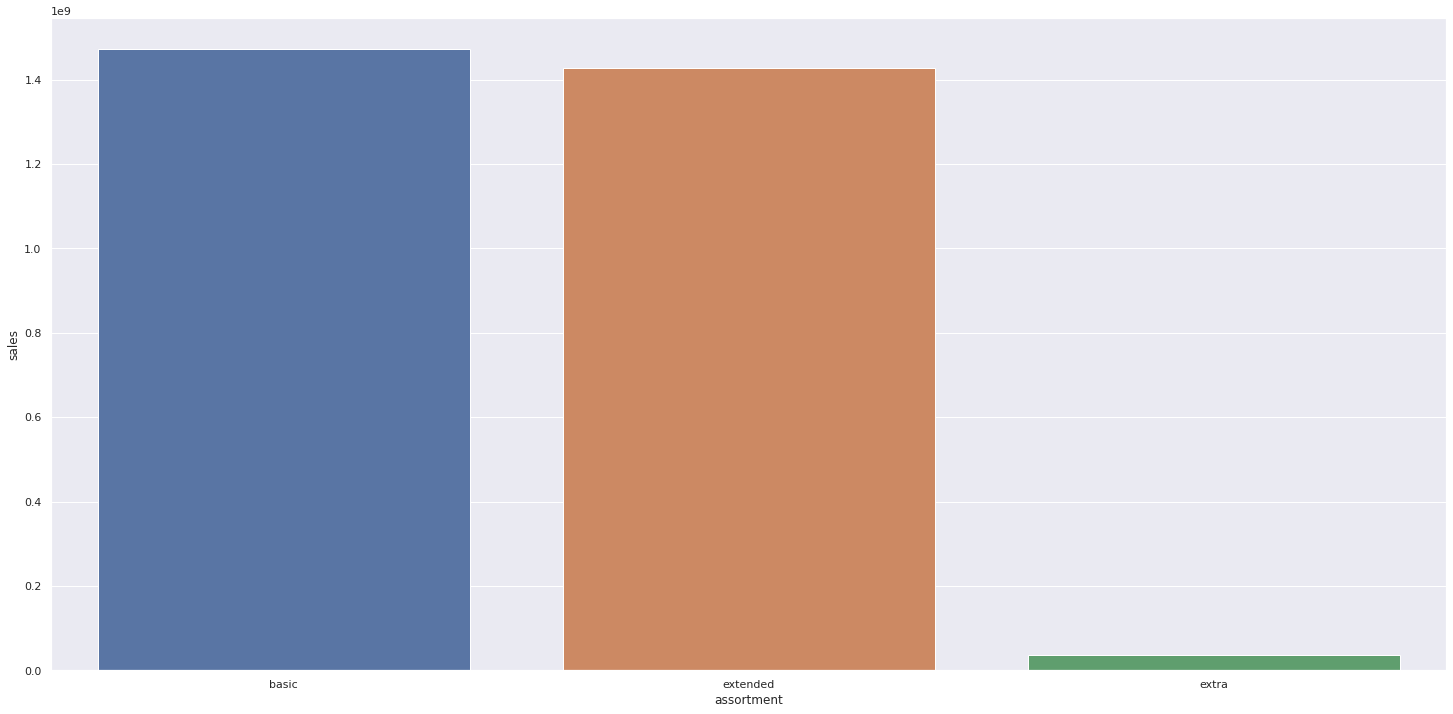

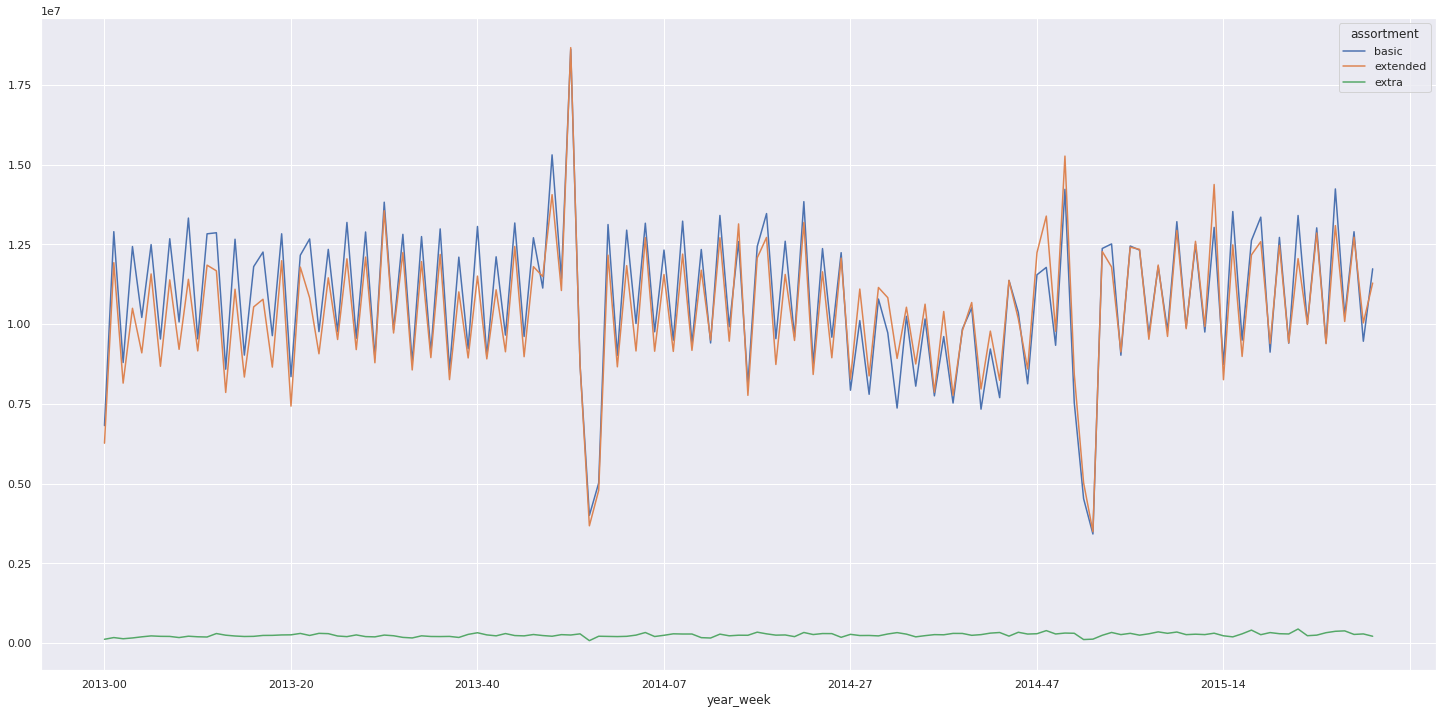

In [35]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1);

aux2 = df4[['assortment','sales','year_week']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment',values='sales').plot()

#aux3 = aux2[aux2['assortment'] == 'extra']
#aux3.pivot(index='year_week',columns='assortment',values='sales').plot()

### 2- Stores with a big amount of competitors probably sell less



**FALSE** Stores where the competitors are closers sell more

<AxesSubplot:>

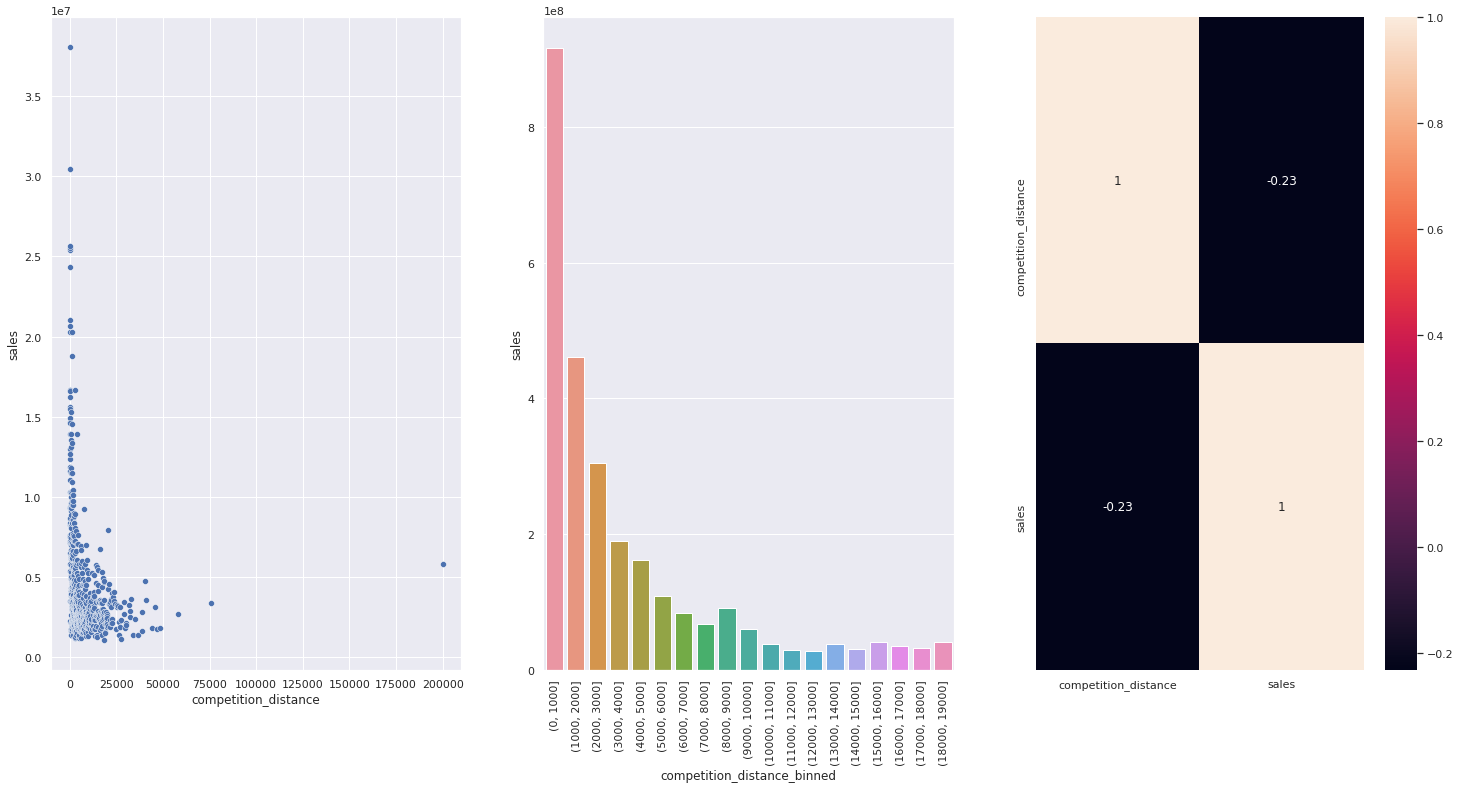

In [36]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux1)

bins = list( np.arange(0,20000,1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned',y='sales',data=aux2)
plt.xticks(rotation=90)


plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### 3- Stores with competitors for a longer period of time probably sell more


**FALSE** Actually stores with competitors what were recently open tends to sell more

<AxesSubplot:>

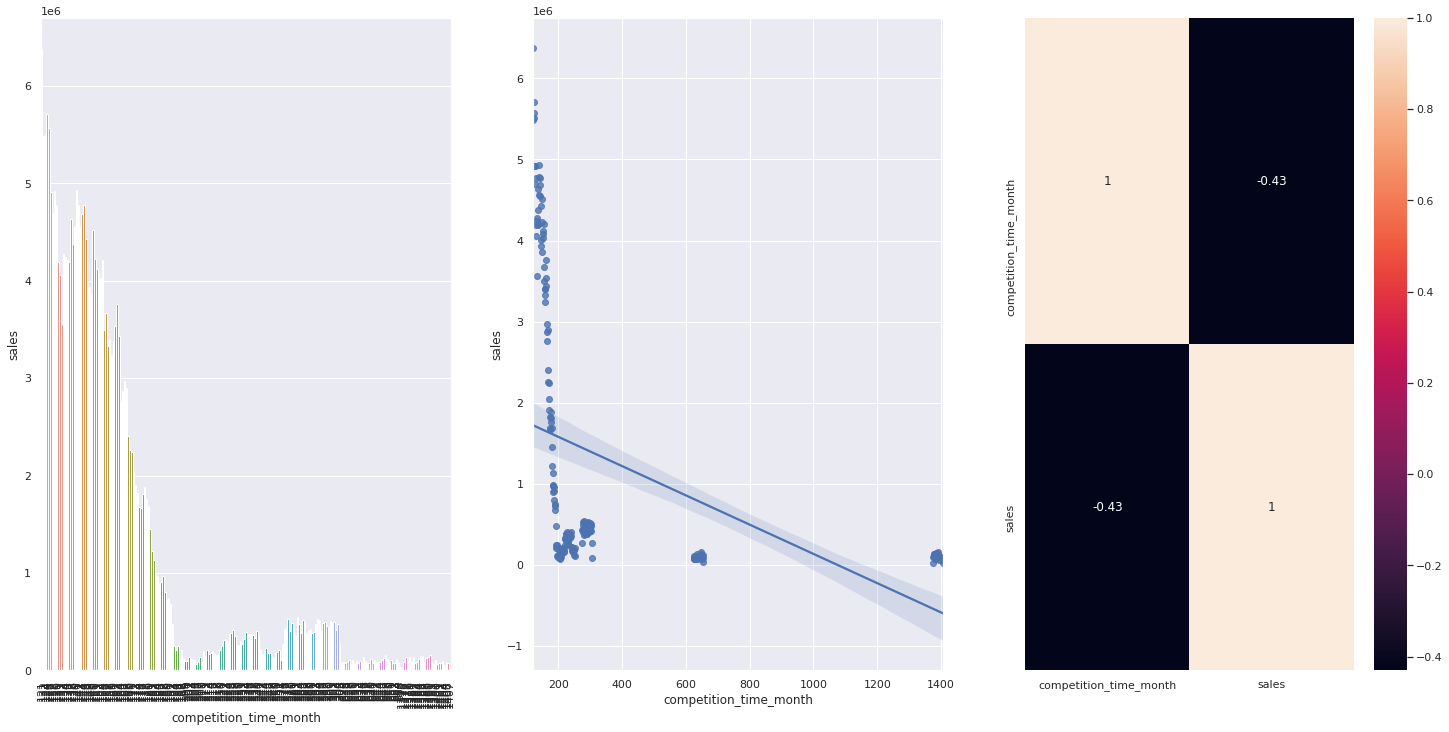

In [37]:
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']>120)& (aux1['competition_time_month'] !=0)]

plt.subplot(1,3,1)
sns.barplot(x='competition_time_month',y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux2)
plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True)


### **4-** Stores with active promotions for longer period of time probably sell more

**FALSE** Actually stores with active promotions for longer periods tends to sell less

<AxesSubplot:>

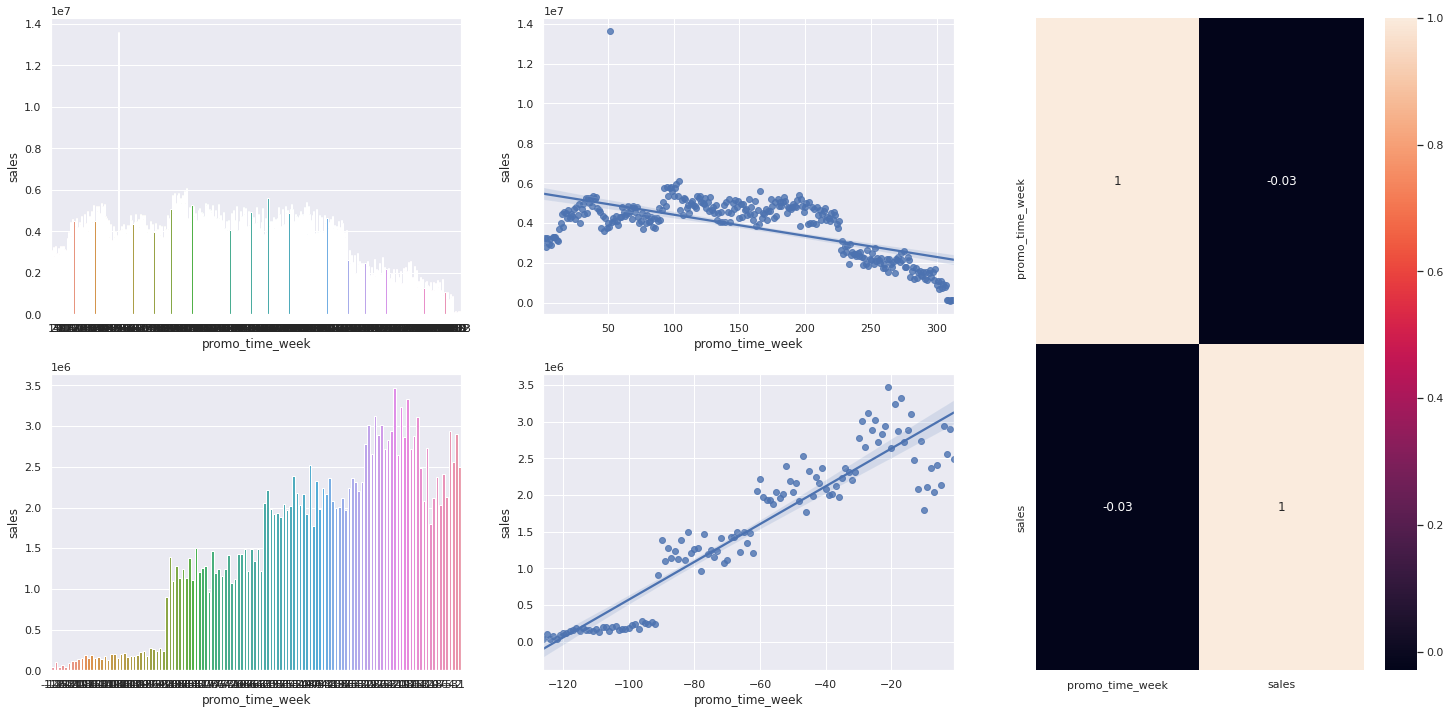

In [38]:
aux1 =df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

aux2 = aux1[aux1['promo_time_week'] > 0]  #extended promotion
plt.subplot(grid[0,0])
sns.barplot(x='promo_time_week', y ='sales',data=aux2)
plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)



aux3 = aux1[aux1['promo_time_week'] < 0]  #regular promo
plt.subplot(grid[1,0])
sns.barplot(x='promo_time_week', y ='sales', data=aux3)
plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y ='sales', data=aux3)
plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### **5-** Stores with a bigger amount of promotional days probably sell more


### **6-** Stores with active promotions for longer period of time probably sell more

**False** Stores with more activate promontion sell less

In [39]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,741976980
1,0,1,645952357
2,1,0,812324138
3,1,1,735532810


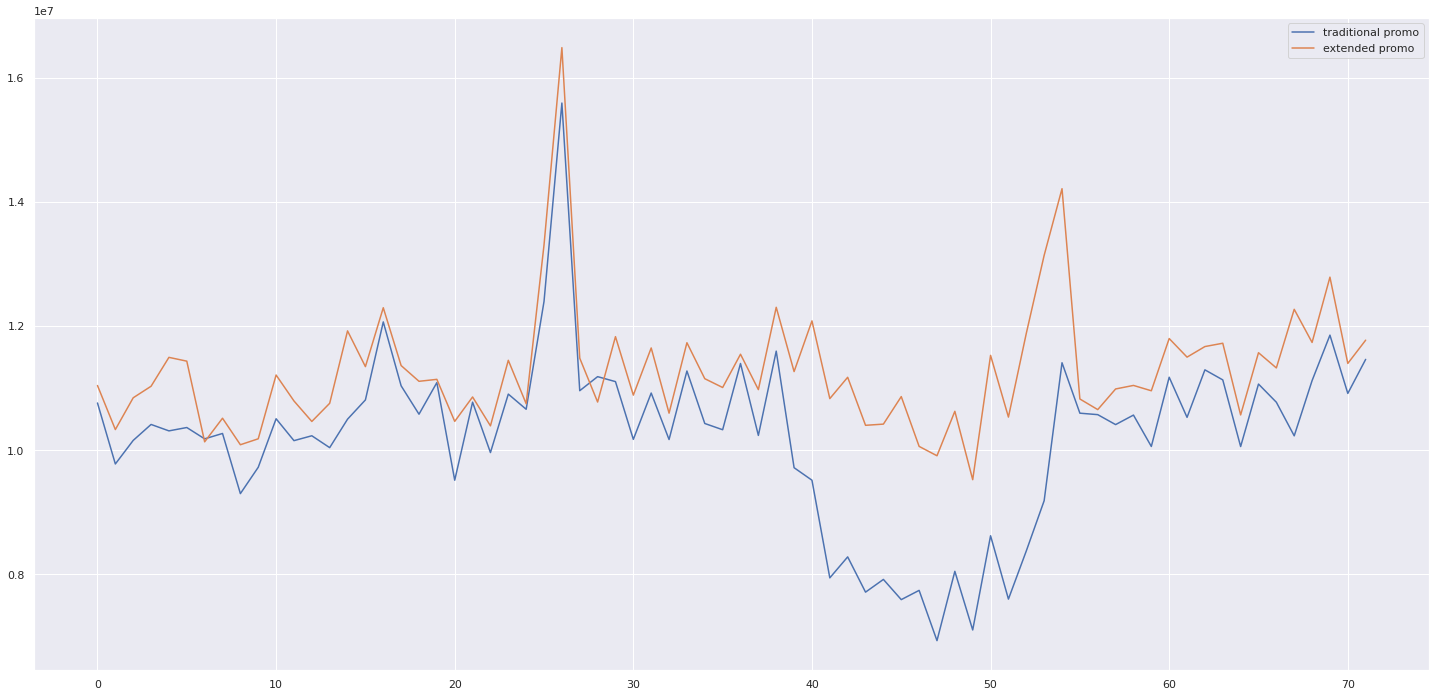

In [40]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend(labels=['traditional promo','extended promo'])



### **8-** Stores probably sell more along the years



**FALSE** Stores tend to sell less along the years.


<AxesSubplot:>

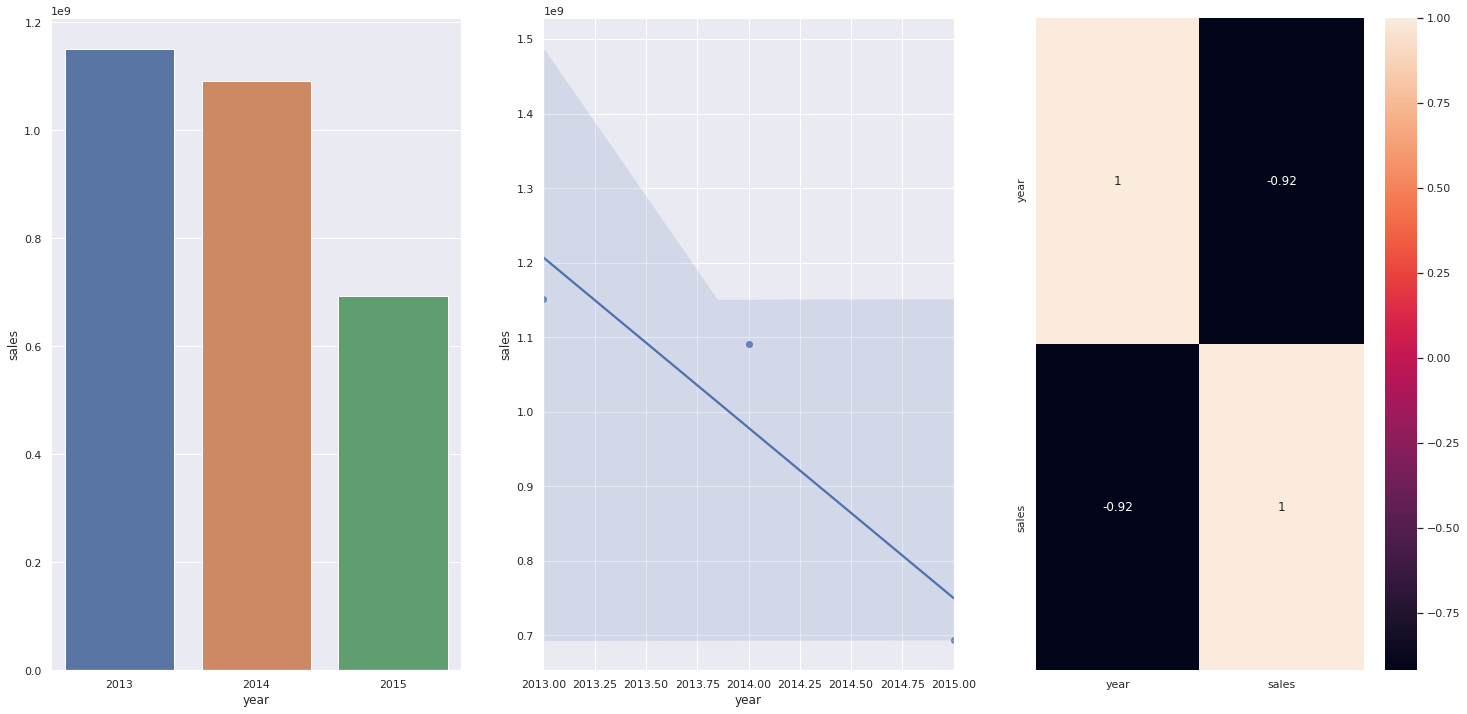

In [41]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1)
plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)


### **10-** Stores open in the second semester of the year probably sell more



**FALSE** Stores tends to sell less in the second semester of the year

<AxesSubplot:>

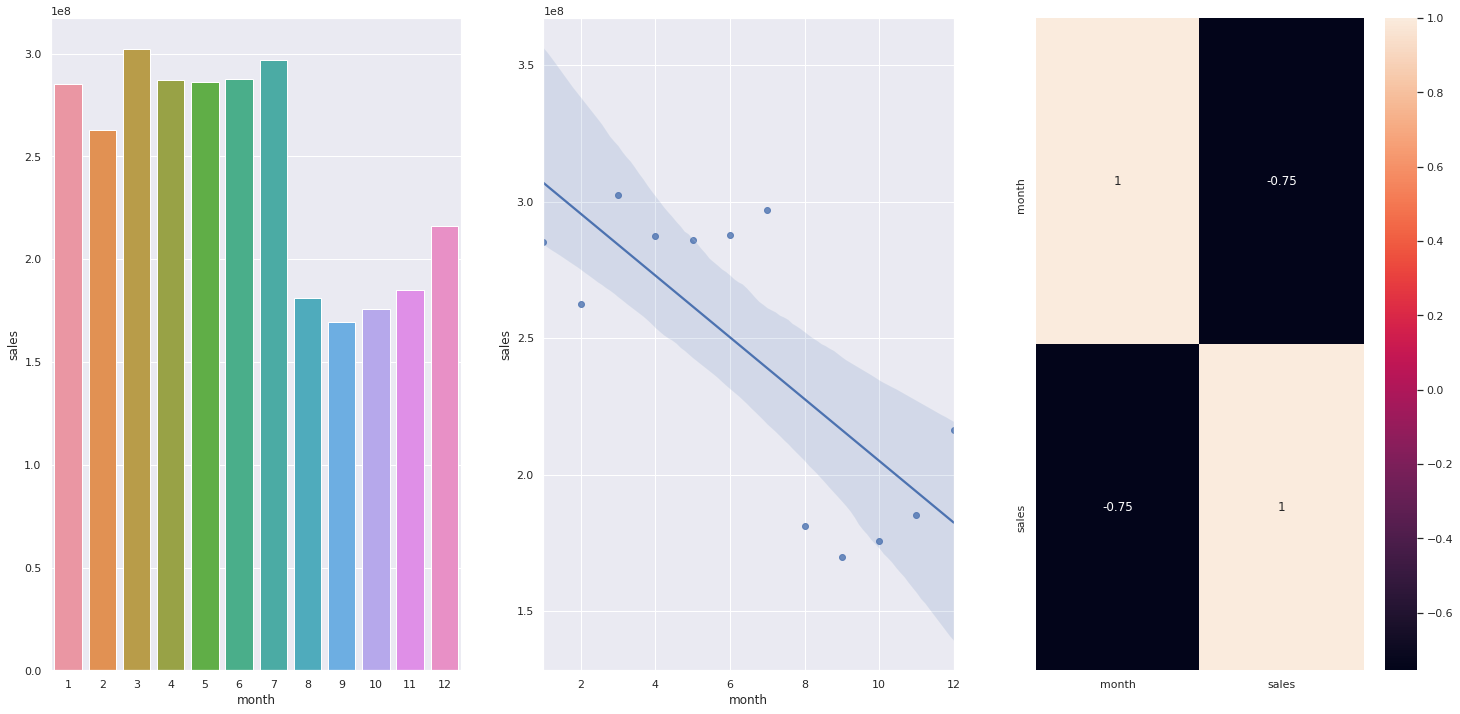

In [42]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux1)
plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)


### **11-** Stores probably sell more after each 10th day of month


**FALSE** Stores tends to sell less after the 10th day of month

In [43]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

<AxesSubplot:>

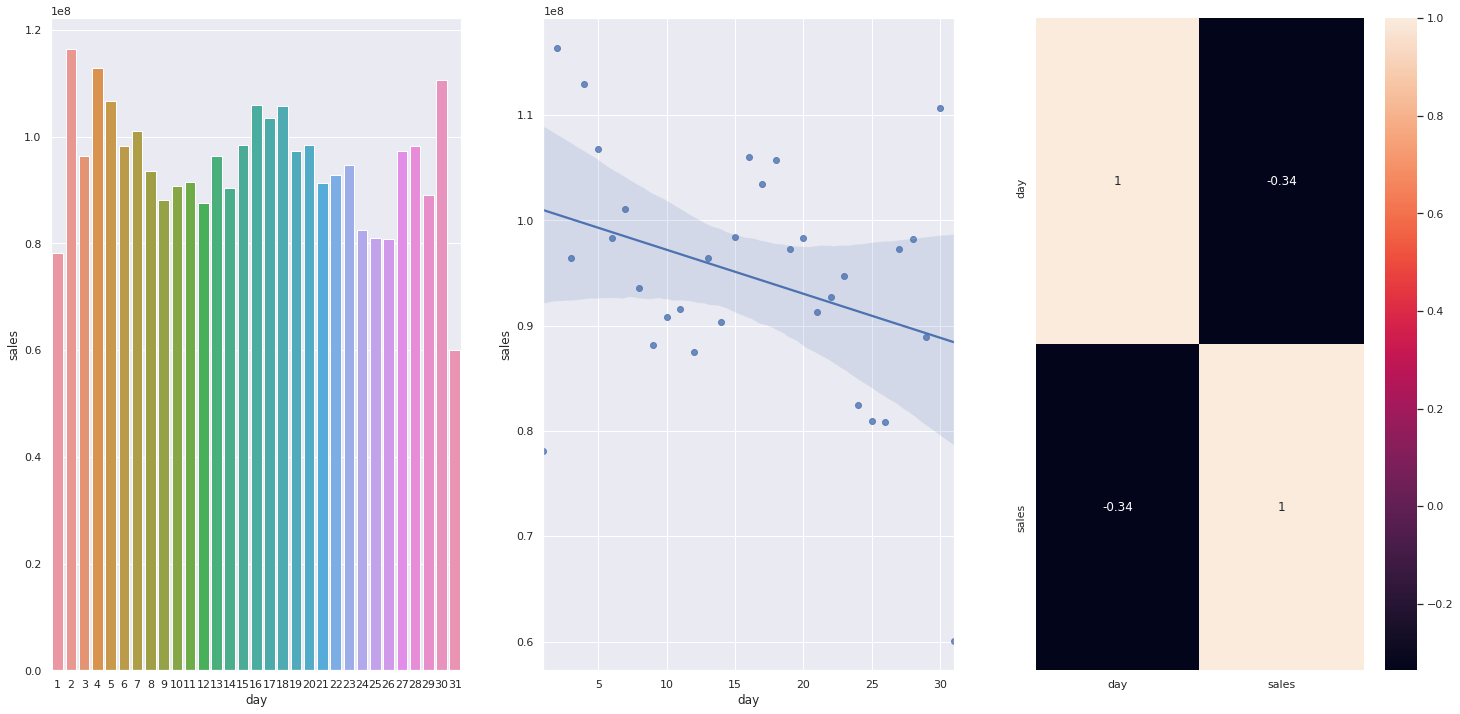

In [44]:
plt.subplot(1,3,1)
sns.barplot(x='day',y='sales',data=aux1)
plt.subplot(1,3,2)
sns.regplot(x='day',y='sales',data=aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)


### **12-** Stores probably sell less in week ends



**True** Stores tend to sell less in week ends

In [45]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

<AxesSubplot:>

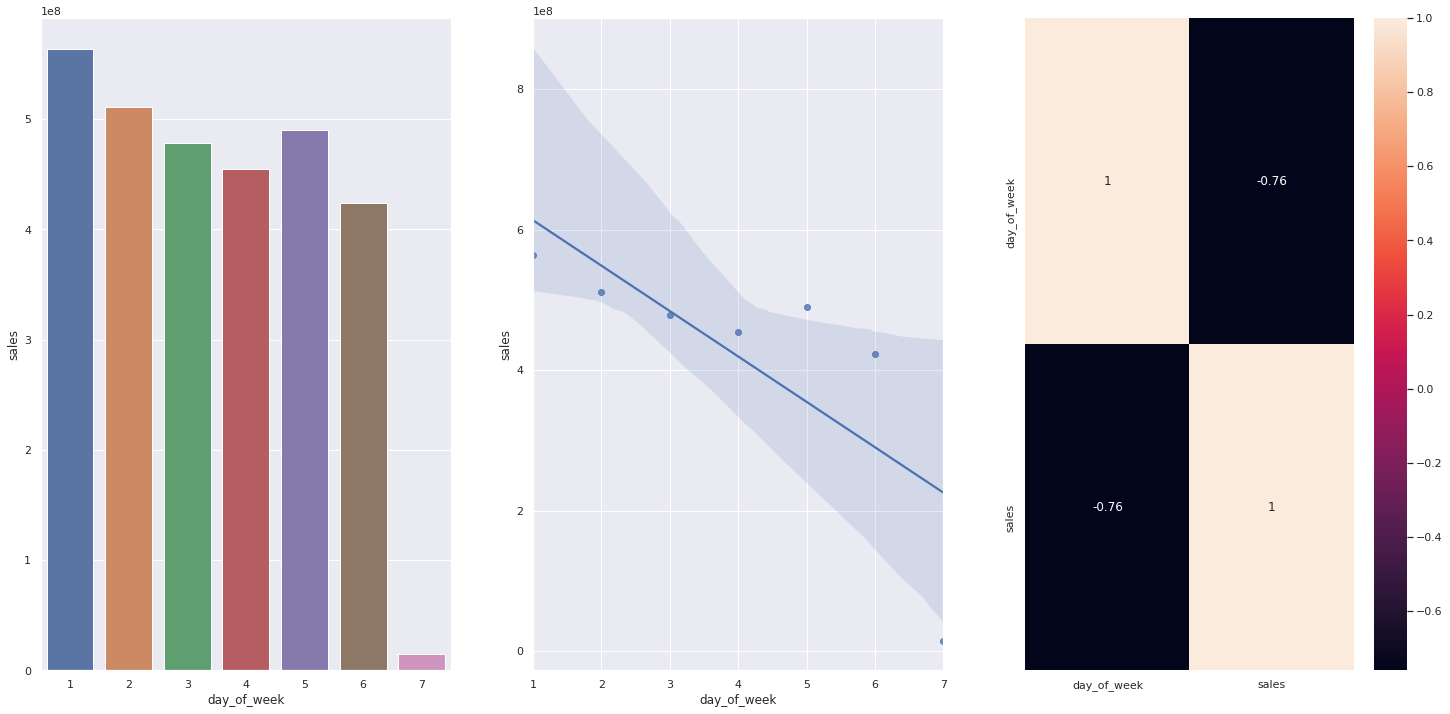

In [46]:
plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux1)
plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

## 4.3 Multivariate analysis

### 4.3.1 Numerical attributes

In [47]:
correlation = num_attributes.corr(method='pearson')

<AxesSubplot:>

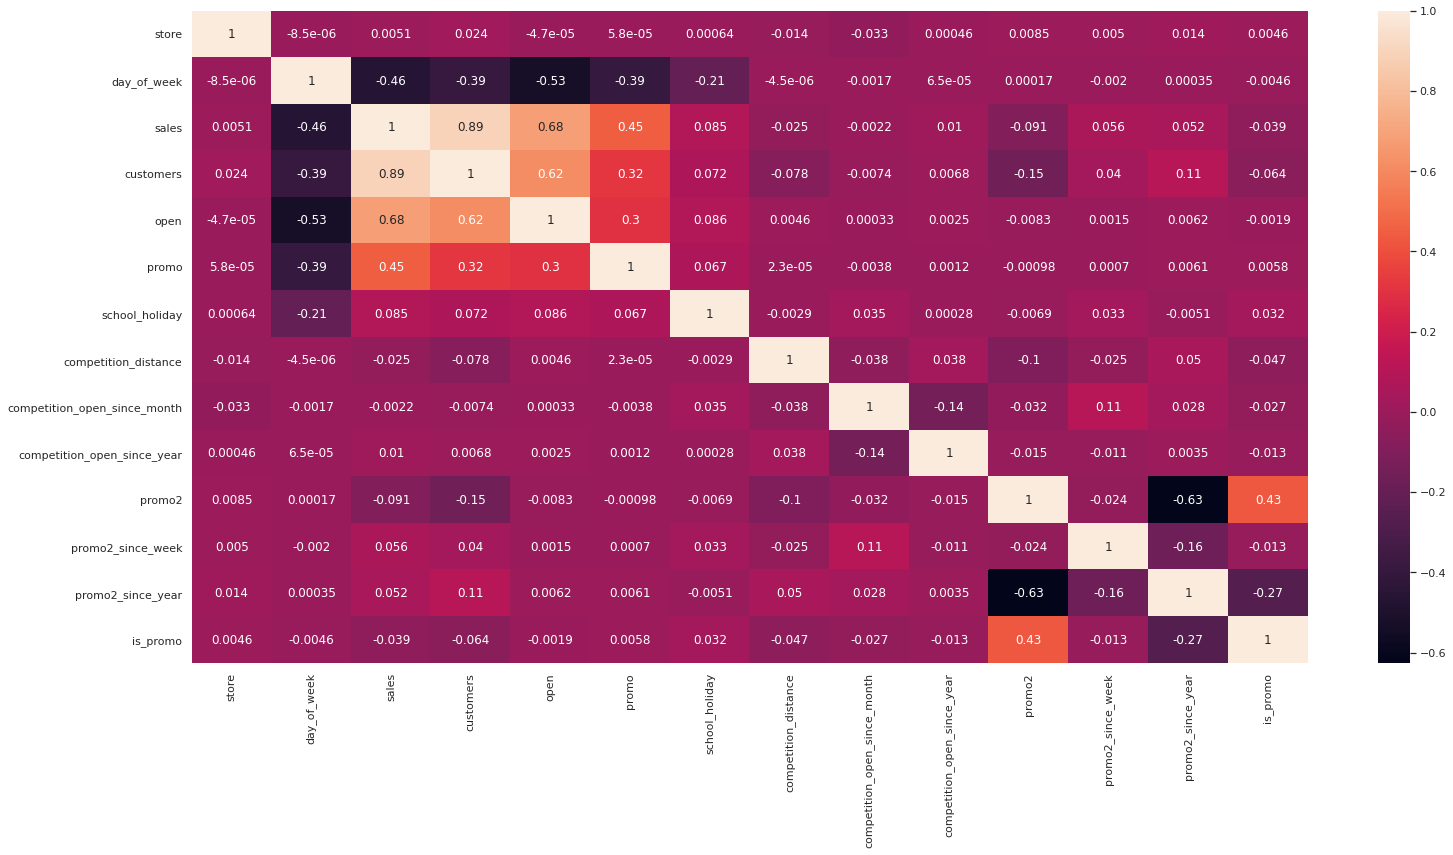

In [48]:
sns.heatmap(correlation,annot=True)

### 4.3.2 Categorical Attributes

In [49]:
cat = df4.select_dtypes(include='object')

In [50]:
a1= cramer_v(cat['state_holiday'],cat['state_holiday'])
a2= cramer_v(cat['state_holiday'],cat['store_type'])
a3= cramer_v(cat['state_holiday'],cat['assortment'])

a4= cramer_v(cat['store_type'],cat['state_holiday'])
a5= cramer_v(cat['store_type'],cat['store_type'])
a6= cramer_v(cat['store_type'],cat['assortment'])

a7= cramer_v(cat['assortment'],cat['state_holiday'])
a8= cramer_v(cat['assortment'],cat['store_type'])
a9= cramer_v(cat['assortment'],cat['assortment'])

In [51]:
d = pd.DataFrame({'state_holiday': [a1,a2,a3],
            'store_type': [a4,a5,a6],
            'assortment': [a7,a8,a9],
             })

d = d.set_index(d.columns)

<AxesSubplot:>

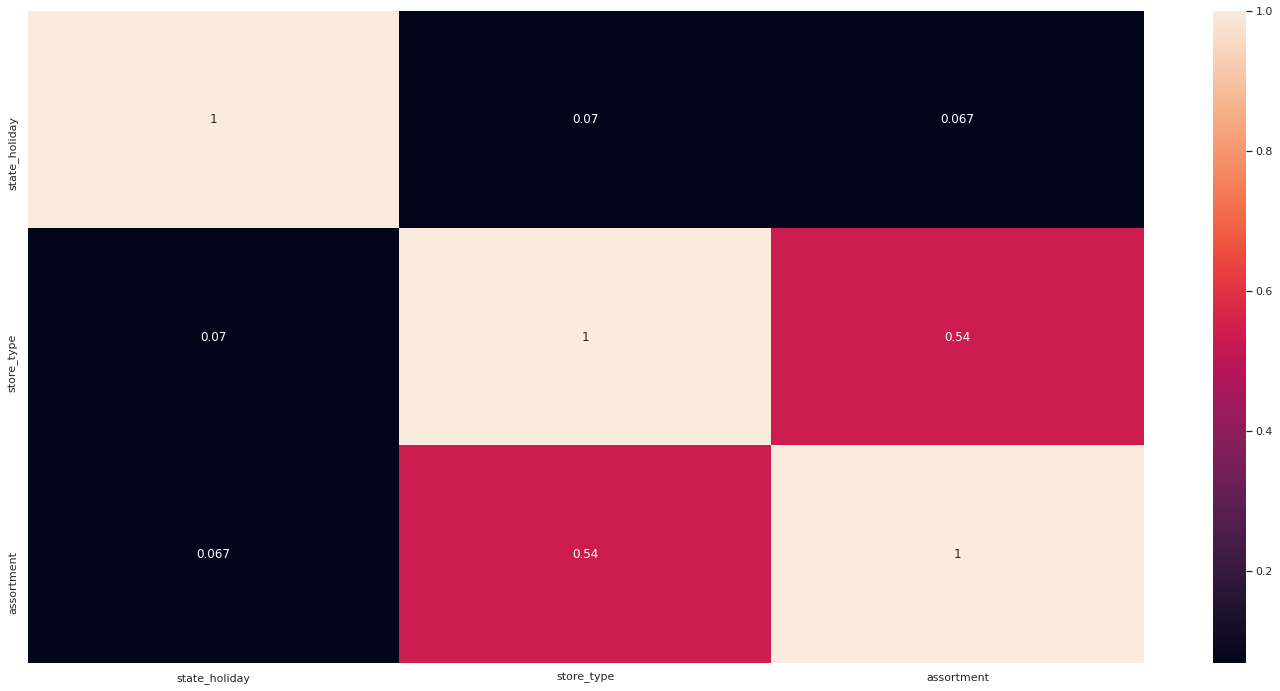

In [52]:
sns.heatmap(d,annot=True)

# 5.0 DATA PREPARATION  

In [53]:
df5 = df4.copy()

## 5.1 Normalization 

In [54]:
#There is not any data with a normal scale, then it is not apropriated to use normalization in this case 

In [55]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
5,6,5,2015-07-31,5651,1,regular_day,1,a,basic,310.0,12,2013,0,31,2015,0,2015,7,31,31,2015-30,2013-12-01,20,2015-07-27,0
8,9,5,2015-07-31,8565,1,regular_day,1,a,extended,2030.0,8,2000,0,31,2015,0,2015,7,31,31,2015-30,2000-08-01,182,2015-07-27,0
9,10,5,2015-07-31,7185,1,regular_day,1,a,basic,3160.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0


## 5.2 Rescaling

In [56]:
rs= RobustScaler()
mms = MinMaxScaler()

In [57]:
#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
#year
df5['year'] = mms.fit_transform( df5[['year']].values )
#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

### 5.3.1 Encoding

In [58]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )


# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [59]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation

In [60]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0. FEATURE SELECTION

In [61]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [62]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [63]:
df6.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
5,6,2015-07-31,8.639765,1,1,0,1,-0.325806,12,2013,0,31,2015,0,1.0,0.054054,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
8,9,2015-07-31,9.055556,1,1,0,3,-0.048387,8,2000,0,31,2015,0,1.0,2.243243,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
9,10,2015-07-31,8.879890,1,1,0,1,0.133871,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [64]:
# training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print( 'Training Min Date: {}'.format( x_train['date'].min() ) )
print( 'Training Max Date: {}'.format( x_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( x_test['date'].min() ) )
print( 'Test Max Date: {}'.format( x_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [65]:
#training and test dataset for Boruta
#x_train_n = x_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

## 6.2.1. Best Features from Boruta

In [66]:
#cols_selected = boruta.support_.tolist()

## best features
#x_train_fs = x_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

### 6.2.3 Manual Features selection

In [67]:
#cols selected include some variables no validated by boruta, but for exploratory analisys
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

In [68]:
# columns to add
feat_to_add = ['date','sales']
cols_selected_boruta.extend(feat_to_add)

In [69]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0 MACHIE LEARNING MODELING

In [ ]:
x_train = x_train[cols_selected_boruta]
x_test = x_test[cols_selected_boruta]
x_train.drop(['date'],axis=1)

In [ ]:
def nl_error(model_name,y,yhat):
    
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'Mape': mape,
                          'RMSE':rmse},index=[0])

def mean_absolute_percentage_error(y, yhat):
   return np.mean( np.abs((y-yhat)/y))


## 7.1 Average Model

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = nl_error('Average Model',np.exp(y_test), np.exp(yhat_baseline))


In [ ]:
baseline_result

## 7.2 Linear Regression Model

In [ ]:
## model
lr = LinearRegression().fit( x_train, y_train )

## prediction
yhat_lr = lr.predict( x_test )

## performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

## 7.3 Linear Regression Regularized Model (Lasso)

In [75]:
x_train.dtypes

store                                    int64
promo                                    int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
competition_time_month                 float64
promo_time_week                        float64
day_of_week_sin                        float64
day_of_week_cos                        float64
month_sin                              float64
month_cos                              float64
day_sin                                float64
day_cos                                float64
week_of_year_sin                       float64
week_of_year_cos                       float64
date                            datetime64[ns]
sales        

In [ ]:
# model
lr = Lasso(alpha=0.01).fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression(Lasso)', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result